Loading data...

Matching ETAD and FTIR data...
Matches found: 104

Cleaning and preparing data...
Final clean data points: 104

Calculating MAC value from regression...
Regression Results:
MAC value (slope): 4.018
Intercept: 28.586
R-squared: 0.817

Generating plots...


/var/folders/q8/4q55gl35679357bs417130z40000gn/T/ipykernel_11578/3671073358.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Month'] = df[date_column].dt.month
/var/folders/q8/4q55gl35679357bs417130z40000gn/T/ipykernel_11578/3671073358.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Season'] = df['Month'].apply(get_season)
/var/folders/q8/4q55gl35679357bs417130z40000gn/T/ipykernel_11578/3671073358.py:100: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a futur


Performing seasonal analysis...

Seasonal Statistics:
         FTIR_EC                        BC_HIPS                 Fabs          
           count      mean       std       mean       std       mean       std
Season                                                                        
Jan-Feb       18  2.892308  0.669854  10.800682  1.629477  43.399128  6.547536
Mar-Apr       18  4.333374  1.781110  11.045611  2.249281  44.383296  9.038024
May-Sept      46  6.771913  1.918690  13.772468  2.307326  55.340311  9.271259
Oct-Dec       22  3.311830  0.616987  10.342731  1.212728  41.558994  4.872965

Seasonal Correlations:
          Correlation  Sample Size
Season                            
Jan-Feb      0.860727         18.0
Mar-Apr      0.888304         18.0
May-Sept     0.897019         46.0
Oct-Dec      0.733041         22.0


/var/folders/q8/4q55gl35679357bs417130z40000gn/T/ipykernel_11578/3671073358.py:261: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  seasonal_correlations = clean_data.groupby('Season').apply(
/var/folders/q8/4q55gl35679357bs417130z40000gn/T/ipykernel_11578/3671073358.py:314: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = model.params[1]
/var/folders/q8/4q55gl35679357bs417130z40000gn/T/ipykernel_11578/3671073358.py:315: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future v


Generating summary statistics...
                   Metric       Value
0             Sample Size  104.000000
1        MAC Value (m²/g)    4.018184
2               R-squared    0.817343
3    FTIR EC Mean (μg/m³)    4.946447
4    HIPS BC Mean (μg/m³)   12.060643
5       FTIR EC Std. Dev.    2.268399
6       HIPS BC Std. Dev.    2.509095
7       Mean Bias (BC-EC)    7.114196
8     Mean Absolute Error    7.114196
9  Root Mean Square Error    7.193793

Analysis complete. Results saved to output/hips_analysis


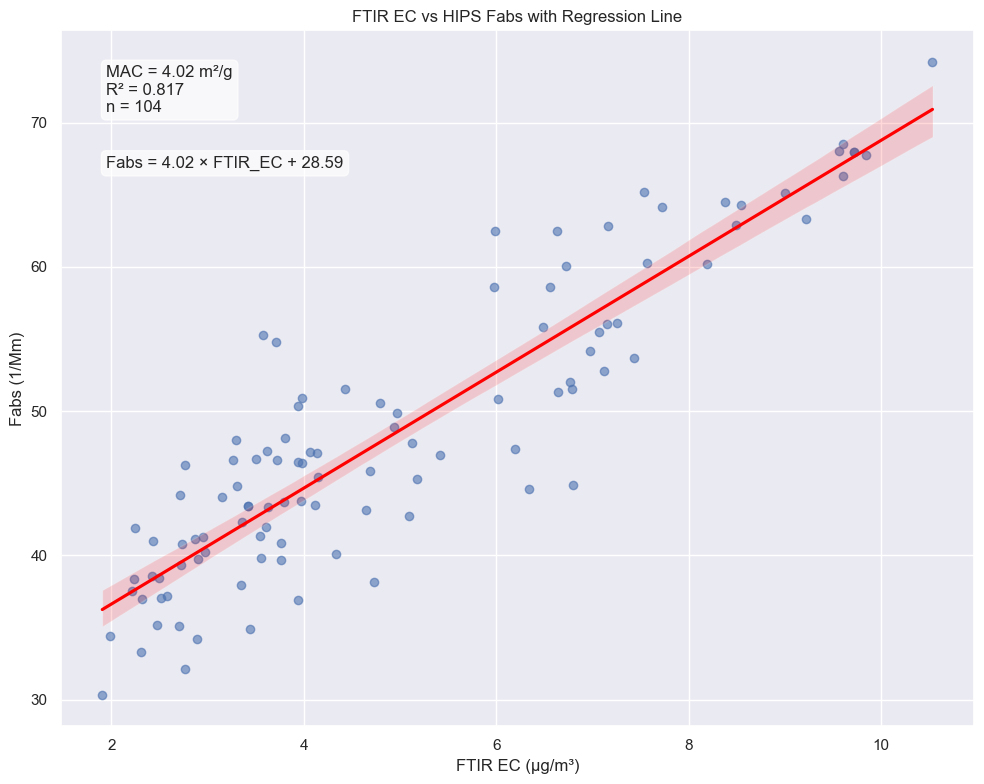

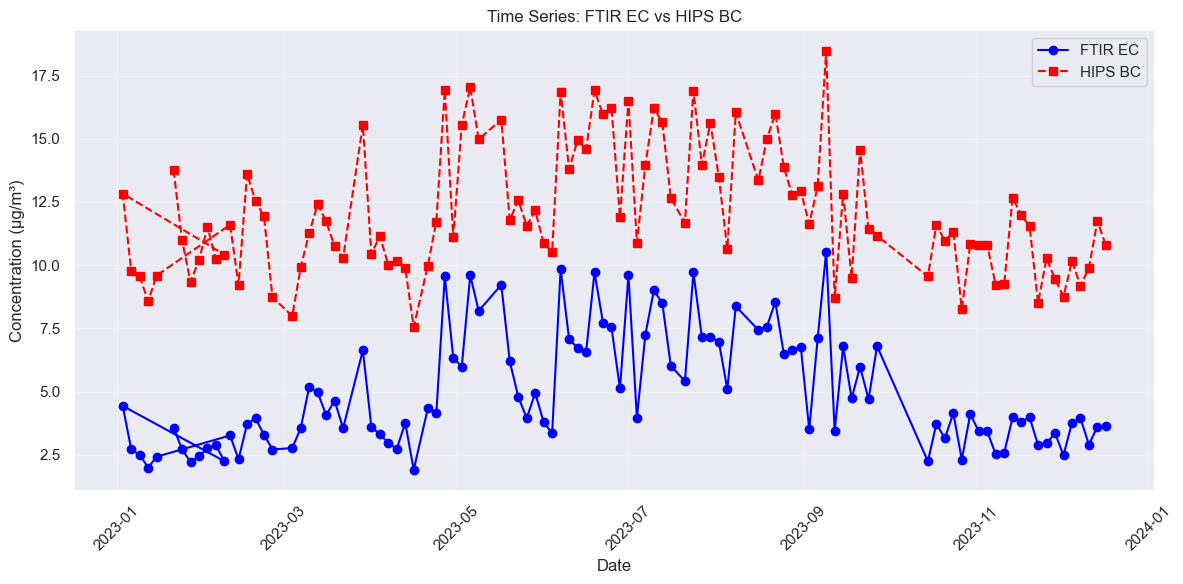

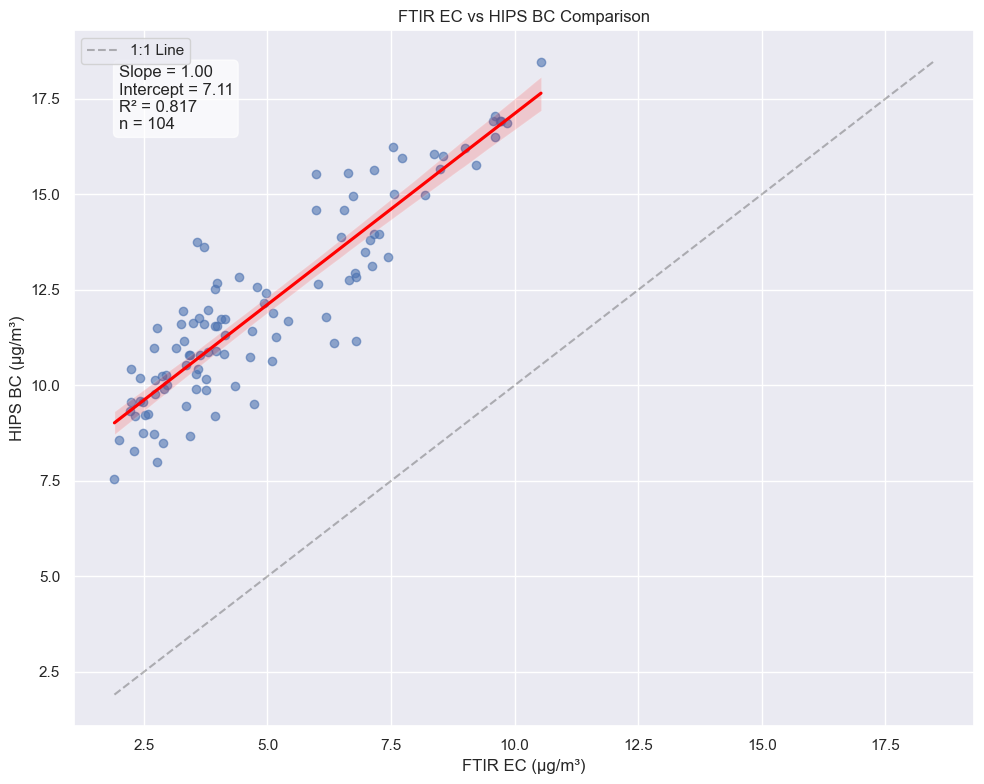

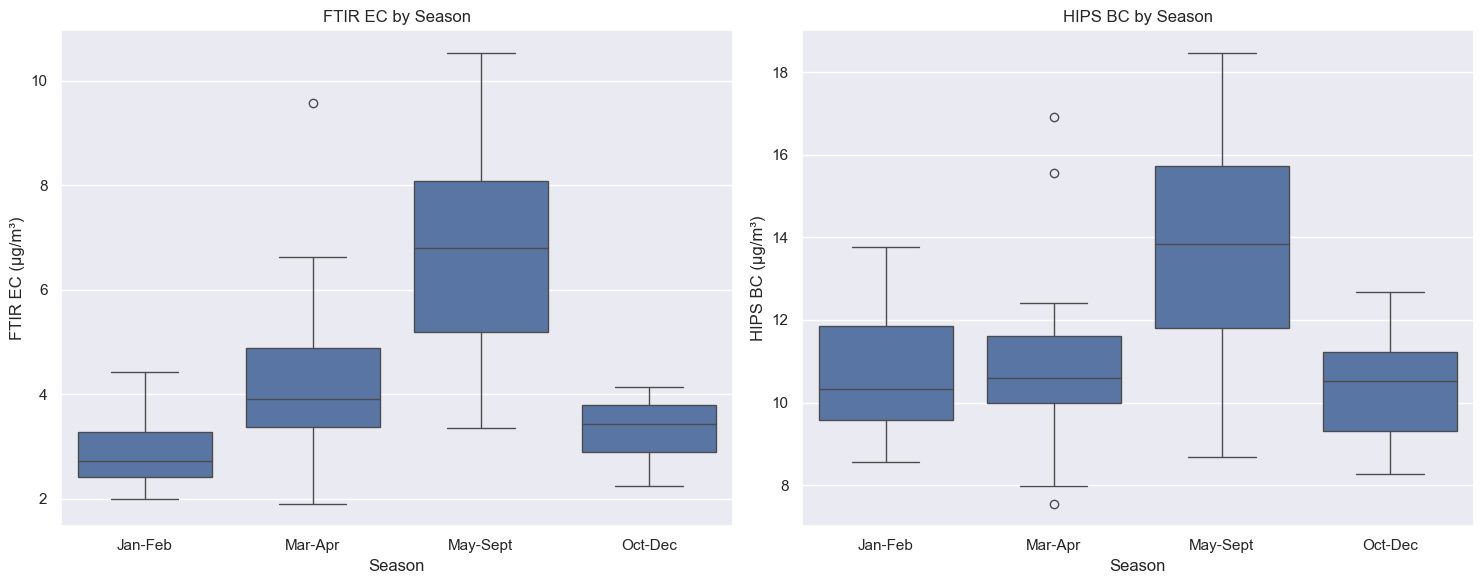

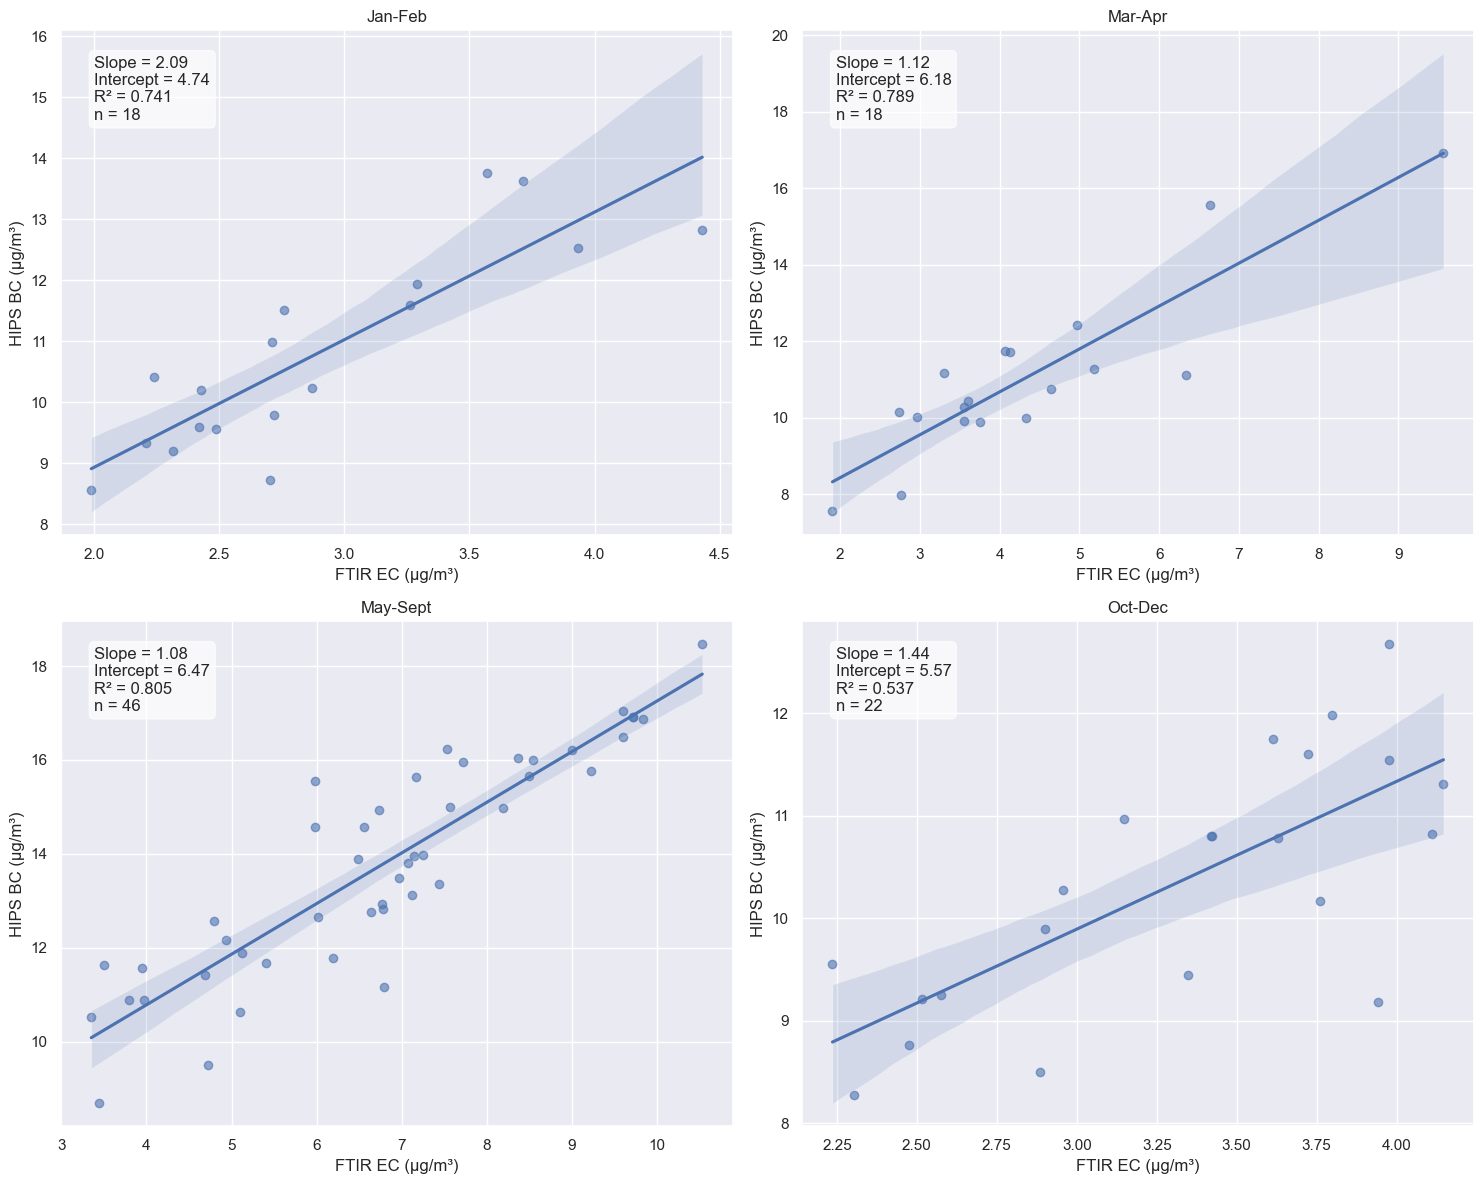

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
import os
from datetime import datetime

# Set plot style
plt.style.use('default')
sns.set_theme()
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

def load_etad_data(filepath):
    """Load and preprocess ETAD data"""
    etad_data = pd.read_csv(filepath)
    etad_data['SampleDate'] = pd.to_datetime(etad_data['SampleDate'])
    return etad_data

def load_ftir_data(filepaths):
    """Load and combine FTIR data from multiple batches"""
    dataframes = []
    for filepath in filepaths:
        df = pd.read_csv(filepath)
        dataframes.append(df)
    
    combined_df = pd.concat(dataframes, ignore_index=True)
    combined_df['date'] = pd.to_datetime(combined_df['date'])
    return combined_df

def create_season_column(df, date_column='SampleDate'):
    """Add season column based on month"""
    # Define seasons for our analysis based on requirements
    def get_season(month):
        if month in [1, 2]:
            return 'Jan-Feb'
        elif month in [3, 4]:
            return 'Mar-Apr'
        elif month in [5, 6, 7, 8, 9]:
            return 'May-Sept'
        else:  # 10, 11, 12
            return 'Oct-Dec'
    
    # Extract month from the date column
    if isinstance(df[date_column].iloc[0], pd.Timestamp):
        df['Month'] = df[date_column].dt.month
    else:
        df['Month'] = pd.to_datetime(df[date_column]).dt.month
    
    # Apply the season mapping
    df['Season'] = df['Month'].apply(get_season)
    return df

def match_etad_ftir_data(etad_data, ftir_data, site='ETAD'):
    """Match ETAD and FTIR data for analysis"""
    # Filter data for the specified site
    etad_filtered = etad_data[etad_data['Site'] == site].copy()
    ftir_filtered = ftir_data[ftir_data['site'] == site].copy()
    
    # Initialize combined dataset
    analysis_data = etad_filtered.copy()
    analysis_data['FTIR_EC'] = np.nan
    
    # Match samples by date
    matches_found = 0
    for idx, row in analysis_data.iterrows():
        matching_ftir = ftir_filtered[
            (ftir_filtered['date'] == row['SampleDate']) &
            (ftir_filtered['site'] == site)
        ]
        if not matching_ftir.empty:
            analysis_data.at[idx, 'FTIR_EC'] = matching_ftir.iloc[0]['FTIR_EC']
            matches_found += 1
    
    print(f"Matches found: {matches_found}")
    return analysis_data

def clean_analysis_data(analysis_data):
    """Clean and prepare data for analysis"""
    # Convert columns to numeric
    analysis_data['FTIR_EC'] = pd.to_numeric(analysis_data['FTIR_EC'], errors='coerce')
    analysis_data['Fabs'] = pd.to_numeric(analysis_data['Fabs'], errors='coerce')
    
    # Remove rows with missing values
    clean_data = analysis_data.dropna(subset=['FTIR_EC', 'Fabs'])
    print(f"Final clean data points: {len(clean_data)}")
    return clean_data

def calculate_mac_from_regression(clean_data):
    """Calculate MAC value from regression of Fabs vs FTIR_EC"""
    # Run regression analysis
    X = clean_data['FTIR_EC']
    y = clean_data['Fabs']
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    
    # Extract slope (MAC value)
    mac = model.params[1]
    intercept = model.params[0]
    r_squared = model.rsquared
    
    print(f"Regression Results:")
    print(f"MAC value (slope): {mac:.3f}")
    print(f"Intercept: {intercept:.3f}")
    print(f"R-squared: {r_squared:.3f}")
    
    return {
        'mac': mac,
        'intercept': intercept,
        'r_squared': r_squared,
        'model': model
    }

def convert_fabs_to_bc(fabs, mac):
    """Convert Fabs (1/Mm) to BC (μg/m³) using MAC value"""
    return fabs / mac

def plot_regression(clean_data, regression_results, output_dir=None):
    """Create regression plot with statistics"""
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create scatter plot
    sns.regplot(data=clean_data, x='FTIR_EC', y='Fabs', 
                scatter_kws={'alpha': 0.6}, line_kws={'color': 'red'}, ax=ax)
    
    # Add regression details
    mac = regression_results['mac']
    intercept = regression_results['intercept']
    r_squared = regression_results['r_squared']
    
    equation = f"Fabs = {mac:.2f} × FTIR_EC + {intercept:.2f}"
    stats_text = f"MAC = {mac:.2f} m²/g\nR² = {r_squared:.3f}\nn = {len(clean_data)}"
    
    # Add text box with statistics
    props = dict(boxstyle='round', facecolor='white', alpha=0.7)
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, 
            verticalalignment='top', bbox=props)
    
    # Add equation
    ax.text(0.05, 0.82, equation, transform=ax.transAxes, 
            verticalalignment='top', bbox=props)
    
    ax.set_title('FTIR EC vs HIPS Fabs with Regression Line')
    ax.set_xlabel('FTIR EC (μg/m³)')
    ax.set_ylabel('Fabs (1/Mm)')
    
    plt.tight_layout()
    
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        plt.savefig(os.path.join(output_dir, 'ftir_ec_vs_hips_fabs_regression.png'), dpi=300)
    
    return fig

def plot_time_series(clean_data, mac, output_dir=None):
    """Create time series plot with both original and converted values"""
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Add calculated BC values
    clean_data = clean_data.copy()
    clean_data['BC_HIPS'] = convert_fabs_to_bc(clean_data['Fabs'], mac)
    
    # Plot FTIR_EC
    ax.plot(clean_data['SampleDate'], clean_data['FTIR_EC'], 'o-', 
            color='blue', label='FTIR EC')
    ax.set_xlabel('Date')
    ax.set_ylabel('Concentration (μg/m³)')
    
    # Plot BC_HIPS on the same y-axis
    ax.plot(clean_data['SampleDate'], clean_data['BC_HIPS'], 's--', 
            color='red', label='HIPS BC')
    
    # Common formatting
    plt.title('Time Series: FTIR EC vs HIPS BC')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        plt.savefig(os.path.join(output_dir, 'ftir_ec_vs_hips_bc_time_series.png'), dpi=300)
    
    return fig

def plot_bc_comparison(clean_data, mac, output_dir=None):
    """Create comparison scatter plot between FTIR EC and calculated HIPS BC"""
    # Calculate BC values
    clean_data = clean_data.copy()
    clean_data['BC_HIPS'] = convert_fabs_to_bc(clean_data['Fabs'], mac)
    
    # Create regression model for BC comparison
    X = clean_data['FTIR_EC']
    y = clean_data['BC_HIPS']
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    
    slope = model.params[1]
    intercept = model.params[0]
    r_squared = model.rsquared
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot scatter and regression line
    sns.regplot(data=clean_data, x='FTIR_EC', y='BC_HIPS', 
                scatter_kws={'alpha': 0.6}, line_kws={'color': 'red'}, ax=ax)
    
    # Add 1:1 line
    min_val = min(clean_data['FTIR_EC'].min(), clean_data['BC_HIPS'].min())
    max_val = max(clean_data['FTIR_EC'].max(), clean_data['BC_HIPS'].max())
    
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3, label='1:1 Line')
    
    # Add statistics
    equation = f"BC_HIPS = {slope:.2f} × FTIR_EC + {intercept:.2f}"
    stats_text = f"Slope = {slope:.2f}\nIntercept = {intercept:.2f}\nR² = {r_squared:.3f}\nn = {len(clean_data)}"
    
    props = dict(boxstyle='round', facecolor='white', alpha=0.7)
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, 
            verticalalignment='top', bbox=props)
    
    ax.set_title('FTIR EC vs HIPS BC Comparison')
    ax.set_xlabel('FTIR EC (μg/m³)')
    ax.set_ylabel('HIPS BC (μg/m³)')
    ax.legend()
    
    plt.tight_layout()
    
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        plt.savefig(os.path.join(output_dir, 'ftir_ec_vs_hips_bc_comparison.png'), dpi=300)
    
    return fig

def analyze_seasonal_data(clean_data, mac, output_dir=None):
    """Analyze and plot data by season"""
    # Calculate BC values
    clean_data = clean_data.copy()
    clean_data['BC_HIPS'] = convert_fabs_to_bc(clean_data['Fabs'], mac)
    
    # Order seasons correctly
    season_order = ['Jan-Feb', 'Mar-Apr', 'May-Sept', 'Oct-Dec']
    
    # Calculate seasonal statistics
    seasonal_stats = clean_data.groupby('Season').agg({
        'FTIR_EC': ['count', 'mean', 'std'],
        'BC_HIPS': ['mean', 'std'],
        'Fabs': ['mean', 'std']
    })
    
    # Reorder the seasons
    seasonal_stats = seasonal_stats.reindex(season_order)
    
    print("\nSeasonal Statistics:")
    print(seasonal_stats)
    
    # Calculate correlations by season
    seasonal_correlations = clean_data.groupby('Season').apply(
        lambda x: pd.Series({
            'Correlation': x['FTIR_EC'].corr(x['BC_HIPS']),
            'Sample Size': len(x)
        })
    )
    
    seasonal_correlations = seasonal_correlations.reindex(season_order)
    print("\nSeasonal Correlations:")
    print(seasonal_correlations)
    
    # Create seasonal box plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Box plot for FTIR EC
    sns.boxplot(data=clean_data, x='Season', y='FTIR_EC', 
                order=season_order, ax=ax1)
    ax1.set_title('FTIR EC by Season')
    ax1.set_xlabel('Season')
    ax1.set_ylabel('FTIR EC (μg/m³)')
    
    # Box plot for HIPS BC
    sns.boxplot(data=clean_data, x='Season', y='BC_HIPS', 
                order=season_order, ax=ax2)
    ax2.set_title('HIPS BC by Season')
    ax2.set_xlabel('Season')
    ax2.set_ylabel('HIPS BC (μg/m³)')
    
    plt.tight_layout()
    
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        plt.savefig(os.path.join(output_dir, 'seasonal_boxplots.png'), dpi=300)
    
    # Create seasonal correlation plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    for i, season in enumerate(season_order):
        season_data = clean_data[clean_data['Season'] == season]
        if len(season_data) > 0:
            ax = axes[i]
            sns.regplot(data=season_data, x='FTIR_EC', y='BC_HIPS', 
                        scatter_kws={'alpha': 0.6}, ax=ax)
            
            # Calculate statistics for this season
            X = season_data['FTIR_EC']
            y = season_data['BC_HIPS']
            if len(X) > 1:  # Need at least 2 points for regression
                X = sm.add_constant(X)
                model = sm.OLS(y, X).fit()
                
                r_squared = model.rsquared
                slope = model.params[1]
                intercept = model.params[0]
                
                stats_text = f"Slope = {slope:.2f}\nIntercept = {intercept:.2f}\nR² = {r_squared:.3f}\nn = {len(season_data)}"
                props = dict(boxstyle='round', facecolor='white', alpha=0.7)
                ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, 
                        verticalalignment='top', bbox=props)
            
            ax.set_title(f'{season}')
            ax.set_xlabel('FTIR EC (μg/m³)')
            ax.set_ylabel('HIPS BC (μg/m³)')
    
    plt.tight_layout()
    
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        plt.savefig(os.path.join(output_dir, 'seasonal_correlations.png'), dpi=300)
    
    return {
        'seasonal_stats': seasonal_stats,
        'seasonal_correlations': seasonal_correlations
    }

def generate_summary_stats(clean_data, mac, regression_results):
    """Generate comprehensive summary statistics"""
    # Calculate BC values
    clean_data = clean_data.copy()
    clean_data['BC_HIPS'] = convert_fabs_to_bc(clean_data['Fabs'], mac)
    
    # Calculate residuals
    clean_data['Residuals'] = clean_data['BC_HIPS'] - clean_data['FTIR_EC']
    
    # Create a summary DataFrame
    summary = pd.DataFrame({
        'Metric': [
            'Sample Size',
            'MAC Value (m²/g)',
            'R-squared',
            'FTIR EC Mean (μg/m³)',
            'HIPS BC Mean (μg/m³)',
            'FTIR EC Std. Dev.',
            'HIPS BC Std. Dev.',
            'Mean Bias (BC-EC)',
            'Mean Absolute Error',
            'Root Mean Square Error'
        ],
        'Value': [
            len(clean_data),
            mac,
            regression_results['r_squared'],
            clean_data['FTIR_EC'].mean(),
            clean_data['BC_HIPS'].mean(),
            clean_data['FTIR_EC'].std(),
            clean_data['BC_HIPS'].std(),
            clean_data['Residuals'].mean(),
            clean_data['Residuals'].abs().mean(),
            np.sqrt((clean_data['Residuals']**2).mean())
        ]
    })
    
    return summary

def main():
    # Setup directories
    output_dir = 'output/hips_analysis'
    os.makedirs(output_dir, exist_ok=True)
    
    # Define filepaths - update these with your actual paths
    etad_data_path = "/Users/ahmadjalil/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/University/Research/Grad/UC Davis Ann/NASA MAIA/Data/EC-HIPS-Aeth Comparison/Data/Original Data/FTIR EC/ETAD_data_2023.csv"
    ftir_data_paths = [
        "/Users/ahmadjalil/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/University/Research/Grad/UC Davis Ann/NASA MAIA/Data/EC-HIPS-Aeth Comparison/Data/Original Data/HIPS BC/SPARTAN_FTIR data batch 2 and 3 resubmitted with MDLs.csv",
        "/Users/ahmadjalil/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/University/Research/Grad/UC Davis Ann/NASA MAIA/Data/EC-HIPS-Aeth Comparison/Data/Original Data/HIPS BC/SPARTAN_FTIR data_batch 4_ Nov2022 to March2024.csv"
    ]
    # Load data
    print("Loading data...")
    etad_data = load_etad_data(etad_data_path)
    ftir_data = load_ftir_data(ftir_data_paths)
    
    # Match data
    print("\nMatching ETAD and FTIR data...")
    analysis_data = match_etad_ftir_data(etad_data, ftir_data)
    
    # Clean data
    print("\nCleaning and preparing data...")
    clean_data = clean_analysis_data(analysis_data)
    
    # Add season column
    clean_data = create_season_column(clean_data)
    
    # Calculate MAC from regression
    print("\nCalculating MAC value from regression...")
    regression_results = calculate_mac_from_regression(clean_data)
    mac = regression_results['mac']
    
    # Create plots
    print("\nGenerating plots...")
    plot_regression(clean_data, regression_results, output_dir)
    plot_time_series(clean_data, mac, output_dir)
    plot_bc_comparison(clean_data, mac, output_dir)
    
    # Seasonal analysis
    print("\nPerforming seasonal analysis...")
    seasonal_results = analyze_seasonal_data(clean_data, mac, output_dir)
    
    # Generate summary statistics
    print("\nGenerating summary statistics...")
    summary_stats = generate_summary_stats(clean_data, mac, regression_results)
    print(summary_stats)
    
    # Save results to CSV
    summary_stats.to_csv(os.path.join(output_dir, 'summary_statistics.csv'), index=False)
    clean_data.to_csv(os.path.join(output_dir, 'processed_hips_data.csv'))
    
    print(f"\nAnalysis complete. Results saved to {output_dir}")
    
    return {
        'clean_data': clean_data,
        'mac': mac,
        'regression_results': regression_results,
        'seasonal_results': seasonal_results,
        'summary_stats': summary_stats
    }

if __name__ == "__main__":
    main()